In [123]:
#import libs 
import pandas as pd 
import numpy as np 
from methods import * 
import random

In [124]:
#import dataset 
iris_df = pd.read_csv("iris.csv")
#zmenit posledny stlpec na boolean
iris_df.loc[iris_df["species"] != "virginica","species"] = 0
iris_df.loc[iris_df["species"] == "virginica","species"] = 1


In [125]:
#y=bool array
y = np.array(iris_df["species"])
#X=matica vlastnosti kvetov
X_pre = iris_df.iloc[:,:4].to_numpy()
#pridat 1 do X
X = np.column_stack((X_pre,np.ones(X_pre.shape[0])))
#x0 ako priemer hodnot, a v ako nasobok * (-2/3) (letmy pohlad na data ukazuje ze 2/3 dat maju byt 0)
avgs = [np.average(iris_df.iloc[:,0]),np.average(iris_df.iloc[:,1]),np.average(iris_df.iloc[:,2]),np.average(iris_df.iloc[:,3])]
dot = [np.prod(avgs)*(-2/3)]
x0 = avgs+dot


In [126]:
#funckia a gradient
#funkcia v maticovom tvare
def fun(beta,x,y):
    return ((y-x@beta)@np.ones(x.shape[0]))**2
n=150
#predratat c
c = -1*np.array([np.sum(X_pre[:, 0]), np.sum(X_pre[:, 1]), np.sum(X_pre[:, 2]), np.sum(X_pre[:, 3]),n])


#gradient funkcie v bode beta(b1,b2,b3,b4,v)
def dfun(beta,x,y, c ):
    ones = np.ones(x.shape[0])
    first_part = (y-x@beta)@ones
    return 2*first_part*c


Porovnanie funkcii


In [127]:
#Const

grad_const_iterations = []
fill_grad_const = lambda x: grad_const_iterations.append(x)
print(grad_const(dfun,x0,callback = fill_grad_const,options={"stepsize" : 1e-7,"tol" : 1e-8,"maxiter":1000},vec=(X,y,c)))

steps_for_plot = []
for i in range (9):
    stepsize = 1 * (0.1 ** i)
    grad_const_iterations = []
    fill_grad_const = lambda x: grad_const_iterations.append(x)
    grad_const(dfun,x0,callback = fill_grad_const,options={"stepsize" : stepsize,"tol" : 1e-8,"maxiter":1000},vec=(X,y,c))
    steps_for_plot.append([stepsize]+grad_const_iterations)



     fun: array([6.62649313e-09, 3.46331603e-09, 4.26242650e-09, 1.35931941e-09,
       1.13402621e-09])
     nit: 105
 success: True
       x: array([  5.34677348,   2.79447454,   3.43925943,   1.09680533,
       -53.68570534])


C:\Users\max\AppData\Local\Temp\ipykernel_9080\424860559.py:14: RuntimeWarning: overflow encountered in multiply
  return 2*first_part*c
C:\Users\max\AppData\Local\Temp\ipykernel_9080\424860559.py:13: RuntimeWarning: overflow encountered in matmul
  first_part = (y-x@beta)@ones
c:\Users\max\Documents\school\MVO\proj2023\methods.py:62: RuntimeWarning: invalid value encountered in add
  x = x + stepsize*s


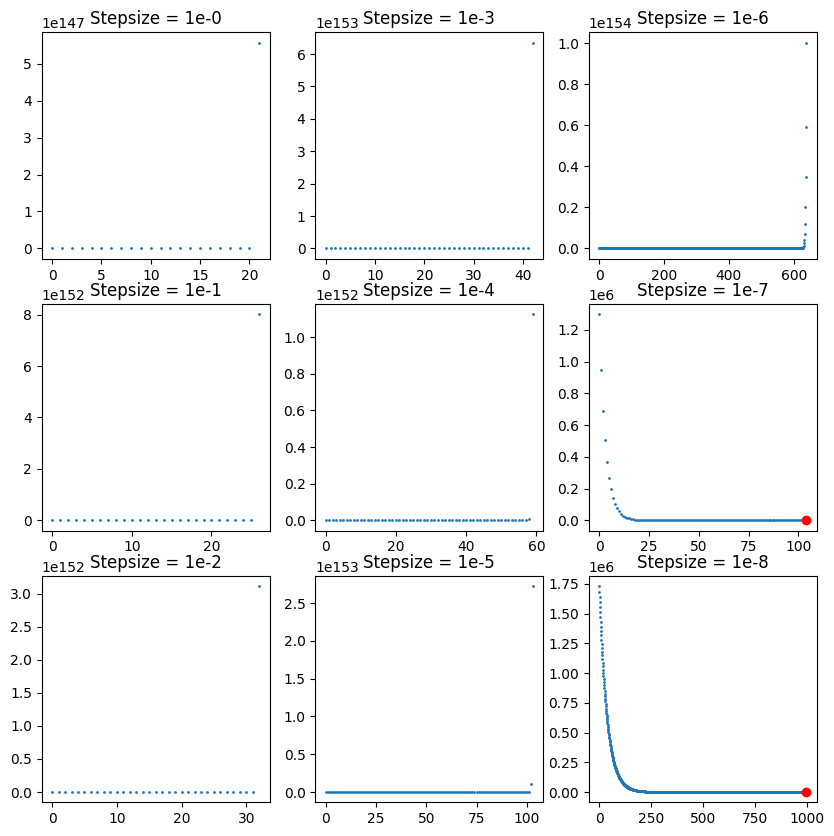

In [128]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3,3,figsize=(10,10))
for i, ys in enumerate(steps_for_plot):
    xi = [n for n in range(len(ys)-1)]
    yi = ys[1:]
    axs[i%3][i//3].scatter(xi,yi,s=1)
    axs[i%3][i//3].scatter(xi[-1],yi[-1],color="red")
    axs[i%3][i//3].set_title(f"Stepsize = 1e-{i}")

In [129]:
#backtrack

print(backtrack(dfun,np.array(x0),args=[fun],options={"tol":1e-8},vec=(X,y,c)))


     fun: array([-1.65662328e-09, -8.65829008e-10, -1.06560663e-09, -3.39829853e-10,
       -2.83506552e-10])
     nit: 7
 success: True
       x: array([  5.34677348,   2.79447454,   3.43925943,   1.09680533,
       -53.68570534])


In [130]:
#cauchy

print(cauchy(dfun,np.array(x0),args=[fun],options={"tol":1e-8},vec=(X,y,c)))


     fun: array([3.28833494e-09, 1.71863803e-09, 2.11518909e-09, 6.74549483e-10,
       5.62749847e-10])
     nit: 6
 success: True
       x: array([  5.34677348,   2.79447454,   3.43925943,   1.09680533,
       -53.68570534])


Classifier

In [131]:
def classifier(x,beta):
    if x@beta >=0:
        return 1
    else:
        return 0

In [132]:
#Cauchy a backtracking nachadza to iste tak whatever dam cauchy lebo menej iteracii
my_beta = cauchy(dfun,np.array(x0),args=[fun],vec=(X,y,c)).x
classificated = []
for row in X:
    xi = row
    c = classifier(xi,my_beta)
    classificated.append(c)

s = 0
for i, flower in enumerate(classificated):
    if flower!=y[i]:
        s+=1
print("Chybovost classifieru: ", s/n)

Chybovost classifieru:  0.22666666666666666


Naivne riesenie splitu


In [133]:
#list indexov 1
virginica_ind = list(iris_df[iris_df["species"]==1].index.values)
other_ind = list(iris_df[iris_df["species"]==0].index.values)
#dataset indicis
dataset_indices = []
#random pick
for i in range(5):
    vpick = random.sample(virginica_ind,5)
    opick = random.sample(other_ind,20)
    dataset_indices.append(vpick+opick)
    for n in vpick: virginica_ind.remove(n)
    for n in opick: other_ind.remove(n)


Train betas

In [134]:
#testovaci set bude posledny
test = dataset_indices[-1]
#ostatne trenovacie
train = dataset_indices[:-1]
betas = []
#pre vsetky trenovacie
for i in train:
    #vypocitame novu tabulku
    #vsade dame prefix new aby sa nic nepokazilo
    new_df = iris_df.iloc[i]
    n=25
    #y=bool array
    y_new = np.array(new_df["species"])
    #X=matica vlastnosti kvetov
    X_new_pre = new_df.iloc[:,:4].to_numpy()
    #pridat 1 do X
    X_new = np.column_stack((X_new_pre,np.ones(X_new_pre.shape[0])))
    c_new = -1*np.array([np.sum(X_new_pre[:, 0]), np.sum(X_new_pre[:, 1]), np.sum(X_new_pre[:, 2]), np.sum(X_new_pre[:, 3]),n])
    avgs = [np.average(new_df.iloc[:,0]),np.average(new_df.iloc[:,1]),np.average(new_df.iloc[:,2]),np.average(new_df.iloc[:,3])]
    dot = [np.prod(avgs)*(-2/3)]
    x0 = avgs+dot
    new_beta = cauchy(dfun,np.array(x0),args=[fun],options={"tol":1e-5},vec=(X_new,y_new,c_new)).x
    betas.append(new_beta)


cross val


In [135]:


new_df = iris_df.iloc[test]
#y=bool array
y_new = np.array(new_df["species"])
#X=matica vlastnosti kvetov
X_pre_new = new_df.iloc[:,:4].to_numpy()
#pridat 1 do X
X_new= np.column_stack((X_pre_new,np.ones(X_pre_new.shape[0])))


for beta in betas:
    classificated = []
    for row in X_new:
        xi = row
        c = classifier(xi,beta)
        classificated.append(c)
    s = 0
    for i, flower in enumerate(classificated):
        if flower!=y_new[i]:
            s+=1
    print("Chybovosť klasifikatoru: ", s/n)

Chybovosť klasifikatoru:  0.28
Chybovosť klasifikatoru:  0.32
Chybovosť klasifikatoru:  0.24
Chybovosť klasifikatoru:  0.12


Ktora vlastnost charakterizuje najlepsie

In [136]:
#asi cez SD 
sds = []
for i in range(4):
    xi = [n[i] for n in betas]
    sds.append(np.std(np.array(xi)))
print("SDs =",sds)

SDs = [0.7288131249525166, 0.35827272513545455, 0.5833285343890893, 0.20438254399317443]


Čím menšia SD, tým je prvok dôležitejší, teda ak by sme chceli preformulovať úlohu tak použijeme len vektor petal_width

In [137]:
#take iste ako predtym len vyberieme posledny prvok
X_pre_new = iris_df.iloc[:,3].to_numpy()
n=150
X_new= np.column_stack((X_pre_new,np.ones(X_pre_new.shape[0])))
c_new = -1*np.array([np.sum(iris_df["petal_width"]),n])
y_new =np.array(iris_df["species"])

x0 = (np.average(iris_df.loc[iris_df["species"]==1,"petal_width"]),-(np.average(iris_df.loc[iris_df["species"]==1,"petal_width"])))
new_beta = cauchy(dfun,np.array(x0),args=[fun],options={"tol":1e-5},vec=(X_new,y_new,c_new)).x
classificated = []
for row in X_new:
    xi = row
    c = classifier(xi,new_beta)
    classificated.append(c)
s = 0
for i, flower in enumerate(classificated):
    if flower!=y_new[i]:
        s+=1
print("Chybovost classifieru: ", s/n)


Chybovost classifieru:  0.2866666666666667
